In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    transform=transforms.ToTensor(),
    download=True,
    train=True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    transform=transforms.ToTensor(),
    download=True,
    train=False
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [3]:
print(train_dataset.classes)
print(train_dataset.data.shape)
print(train_dataset.data.max())
print(train_dataset.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
torch.Size([60000, 28, 28])
tensor(255, dtype=torch.uint8)
tensor([9, 0, 0,  ..., 3, 0, 5])


# **K = number of classes**

In [4]:
K = len(train_dataset.classes)
print(f'Number of classes: {K}')

Number of classes: 10


# **Define the model**

Output size of a convolutional layer :


*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride



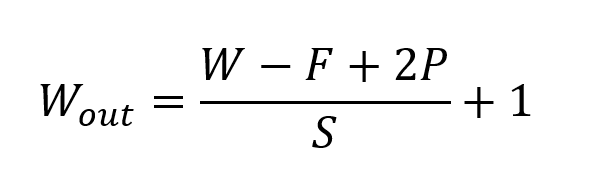

In [5]:
from math import floor

def conv_arithmetic(height, padding, kernel_size, stride, dilation = 1):
  "Number of input neurons for the first dense layer post convolutions "
  return floor(((height + 2*padding - dilation * (kernel_size - 1) - 1) / stride) +1)

conv_arithmetic(height=128, 
                padding=1, 
                kernel_size=3, 
                stride=1)

128

In [6]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__() # super refers to CNN i.e. the parent class
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU(),
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128 *2 *2, 512), # out3 * width3 * height3
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, K)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [7]:
model = CNN(K)

# **Using the flatten layer**



```
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128 *2 *2, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, K)
)
```



In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [10]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [11]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[it], test_losses[it] = train_loss,  test_loss

    dt = datetime.now() - t0

    print(f'Epoch {it+1} / {epochs}: Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}, duration: {dt}')

  return train_losses, test_losses

In [12]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1 / 15: Train Loss : 0.6518, Test Loss : 0.4772, duration: 0:00:13.952460
Epoch 2 / 15: Train Loss : 0.4323, Test Loss : 0.4053, duration: 0:00:06.898937
Epoch 3 / 15: Train Loss : 0.3767, Test Loss : 0.3653, duration: 0:00:06.896171
Epoch 4 / 15: Train Loss : 0.3398, Test Loss : 0.3347, duration: 0:00:06.914231
Epoch 5 / 15: Train Loss : 0.3154, Test Loss : 0.3333, duration: 0:00:06.886204
Epoch 6 / 15: Train Loss : 0.2950, Test Loss : 0.3105, duration: 0:00:06.834331
Epoch 7 / 15: Train Loss : 0.2753, Test Loss : 0.3043, duration: 0:00:08.270484
Epoch 8 / 15: Train Loss : 0.2601, Test Loss : 0.2965, duration: 0:00:06.864553
Epoch 9 / 15: Train Loss : 0.2446, Test Loss : 0.2905, duration: 0:00:06.843561
Epoch 10 / 15: Train Loss : 0.2306, Test Loss : 0.2876, duration: 0:00:06.914372
Epoch 11 / 15: Train Loss : 0.2194, Test Loss : 0.2817, duration: 0:00:07.500062
Epoch 12 / 15: Train Loss : 0.2054, Test Loss : 0.2853, duration: 0:00:06.900685
Epoch 13 / 15: Train Loss : 0.1922, T

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

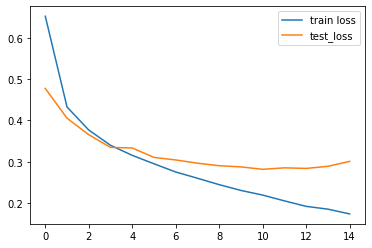

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.plot

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.79      0.90      0.84      1000
       Dress       0.91      0.89      0.90      1000
        Coat       0.85      0.83      0.84      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.74      0.67      0.70      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



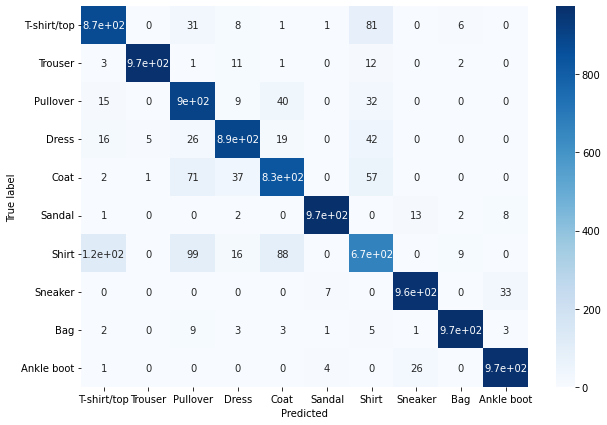

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

def report(loader):
  is_correct = 0
  p_test = np.array([])
  model.eval()
  
  eval_set = test_dataset

  X_test = eval_set.data.numpy()
  y_test = eval_set.targets.numpy()

  for inputs, targets in loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

  print(classification_report(y_test, p_test, target_names=test_dataset.classes))
  cm = confusion_matrix(y_test, p_test)
  plt.figure(figsize=(10,7))
  sns.heatmap(cm, cmap='Blues', annot=True, xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
  plt.xlabel('Predicted')
  plt.ylabel('True label')
  plt.show()

  return p_test, y_test

p_test, y_test = report(loader=test_loader)

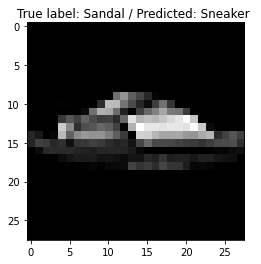

In [29]:
p_test = p_test.astype(np.uint8)
X_test = test_dataset.data.numpy()
misclassified_idx = np.where(y_test != p_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i].reshape(28,28), cmap='gray')
plt.title(f"True label: {test_dataset.classes[y_test[i]]} / Predicted: {test_dataset.classes[p_test[i]]} ")
plt.show()